# Statistics on missing CA and CB atoms AND side chain angles

## Aims of this notebook

### 1. Missing CA and CB atoms

In our fingerprint, both the exposure and side chain angle features are dependent on CA and CB atoms.
Here, we investigate where and overall how often these atoms are missing in the KLIFS data.

1. Get for each KLIFS molecule CA and CB atom coordinates per residue position.
2. Calculate missing atom rate per residue position: CA, CB and CA+CB missing.

### 2. Side chain angle (SCA) distribution

SCA shall describe (as the name says) the angle of a side chain. We need to make sure that the SCA is not an additional measure of size (we have that already in our fingerprint) but can truly show different angles of a specific amino acid. 

Small amino acids (with tiny side chains) should not show much angle diversion (with smaller angles), larger ones should (with larger angles).

1. Calculate for each amino acid the angle distribution.
2. Save molecule and residue code for each angle, in order to trace back interesting angles.
3. Check diversity of angles per amino acid. If no diversity observed, side chain angle might not be such a good measure, since it does not depend on structural conformation but solely on amino acid type.

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from pathlib import Path
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.analysis import ResidueConservation, GapRate, SideChainAngleStatistics

sns.set()
%matplotlib inline

## IO paths

In [4]:
path_to_kinsim = Path('.') / '..' / '..'
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'

path_to_results = path_to_kinsim / 'examples'/ 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load KLIFS metadata

In [5]:
klifs_metadata = pd.read_csv(metadata_path, index_col=0)

In [6]:
klifs_metadata.shape

(3878, 23)

In [7]:
klifs_metadata.head()

,metadata_index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
0,2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,KSA,...,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,HUMAN/AAK1/4wsq_chainB_altA
1,10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",LKB,...,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,HUMAN/AAK1/5l4q_chainA_altA
2,7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,XIN,...,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,HUMAN/AAK1/5te0_chainA
3,843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,VX6,...,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,HUMAN/ABL1/2f4j_chainA
4,815,ABL1,Abl,TK,2g1t,A,-,Human,-,-,...,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,HUMAN/ABL1/2g1t_chainA


## Data generation

In [8]:
gap_rate = GapRate(klifs_metadata)

## Gap rate

In [9]:
gap_rate.data.iloc[40:55]

,klifs_id,gaps,gap_rate
klifs_id,,,
41,41,1,0.0003
42,42,3,0.0008
43,43,1,0.0003
44,44,0,0.0000
45,45,0,0.0000
46,46,1,0.0003
47,47,5,0.0013
48,48,1,0.0003
49,49,9,0.0023


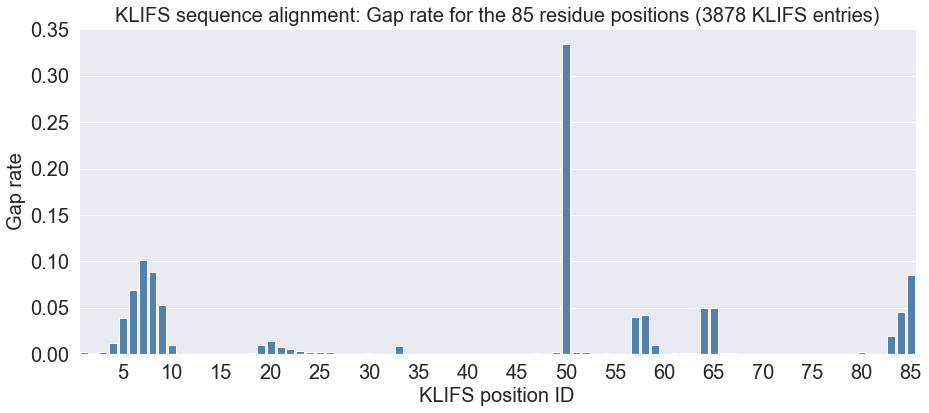

In [10]:
gap_rate.plot_gap_rate(
    path_to_results / 'features'
)

## Missing CA and CB atoms

In [11]:
with open(path_to_results / 'features' / 'stats_missing_ca_cb_and_sca.p', 'rb') as f:
    sca_stats = pickle.load(f)

In [12]:
sca_stats.data.head()

,klifs_id,residue_id,residue_name,ca,cb,centroid,sca,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB


In [13]:
sca_stats.data.shape

(325170, 8)

In [14]:
sca_stats.get_missing_residues_ca_cb(gap_rate)

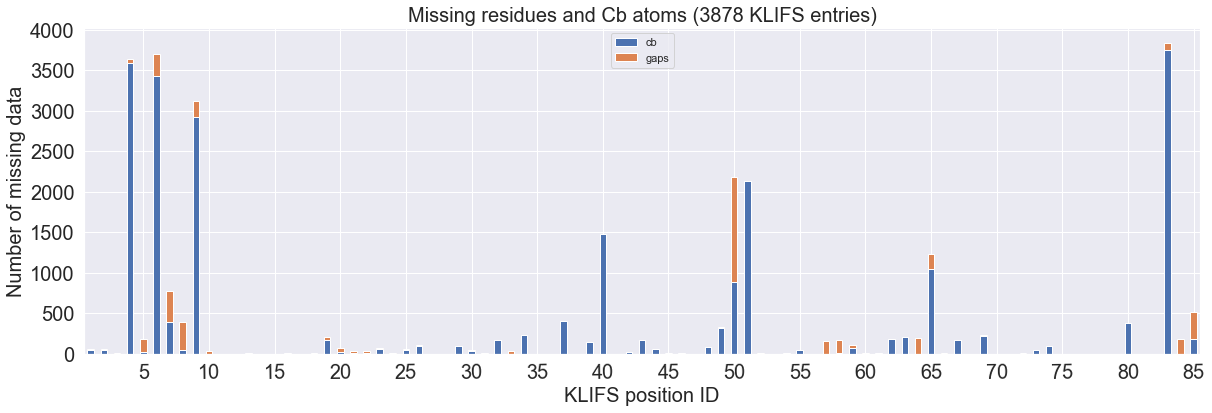

In [15]:
sca_stats.plot_missing_residues_ca_cb(
    path_to_results / 'features'
)

## SCA angle distribution

In [16]:
sca_stats.data.head()

,klifs_id,residue_id,residue_name,ca,cb,centroid,sca,klifs_code
0,1,50,GLU,"<Vector -3.20, -23.46, -71.05>","<Vector -2.63, -22.05, -70.79>","<Vector -2.21, -22.21, -70.68>",94.16,HUMAN/AAK1_4wsq_altA_chainB
1,2,51,VAL,"<Vector -5.75, -22.67, -73.74>","<Vector -7.30, -22.87, -73.72>","<Vector -6.41, -22.39, -73.68>",21.29,HUMAN/AAK1_4wsq_altA_chainB
2,3,52,LEU,"<Vector -4.47, -19.59, -75.71>","<Vector -3.26, -19.64, -76.63>","<Vector -3.57, -19.55, -75.95>",27.98,HUMAN/AAK1_4wsq_altA_chainB
3,4,53,ALA,"<Vector -7.51, -18.97, -77.92>","<Vector -7.14, -17.87, -78.92>","<Vector -7.42, -19.51, -78.32>",22.51,HUMAN/AAK1_4wsq_altA_chainB
4,5,54,GLU,"<Vector -10.51, -20.69, -79.50>","<Vector -11.48, -21.24, -78.46>","<Vector -11.07, -20.30, -79.60>",25.87,HUMAN/AAK1_4wsq_altA_chainB


In [17]:
# How many residues have a missing Cb but are not GLY?
sca_stats.data[
    (sca_stats.data.cb.isna()) &
    (sca_stats.data.residue_name != 'GLY')
].shape

(50, 8)

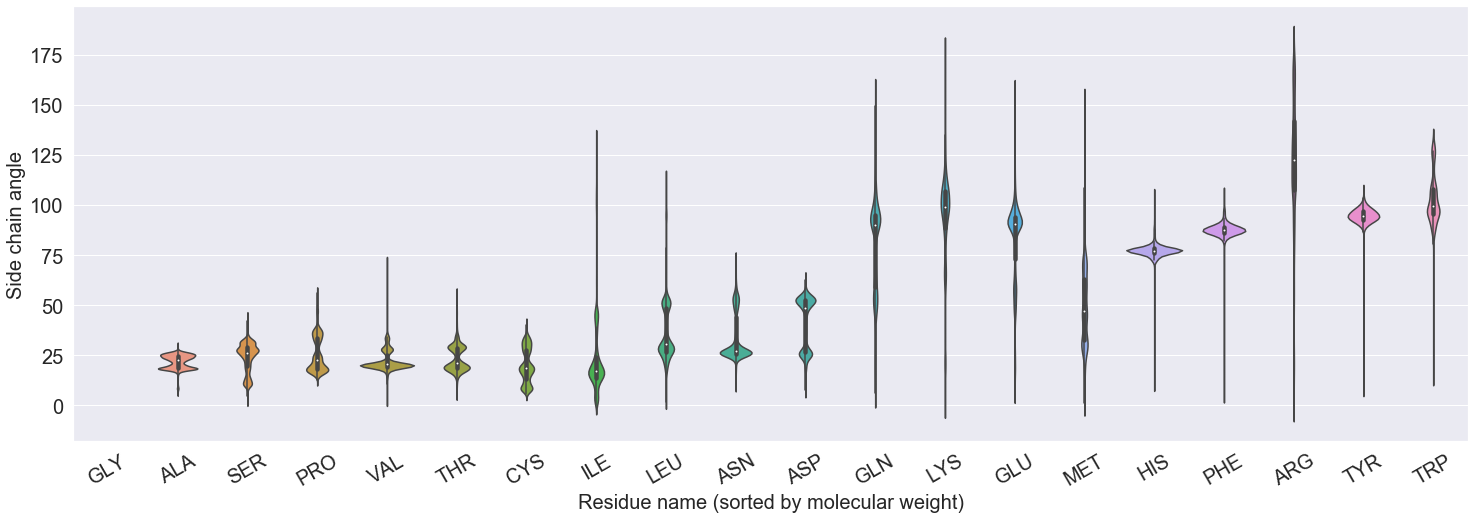

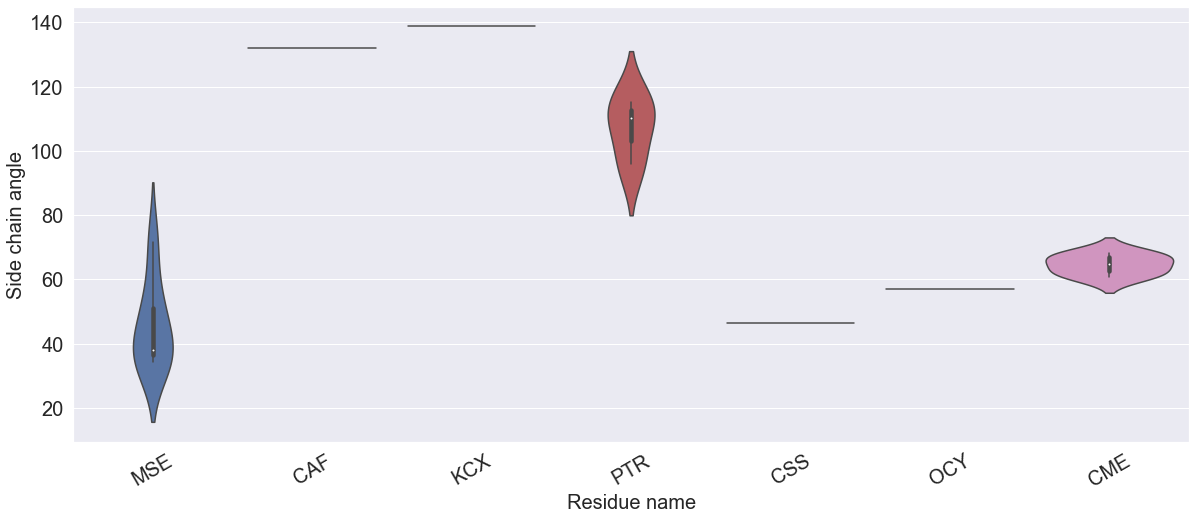

In [18]:
sca_stats.plot_side_chain_angle_distribution(
    path_to_results / 'features', 
    kind='violin'
)

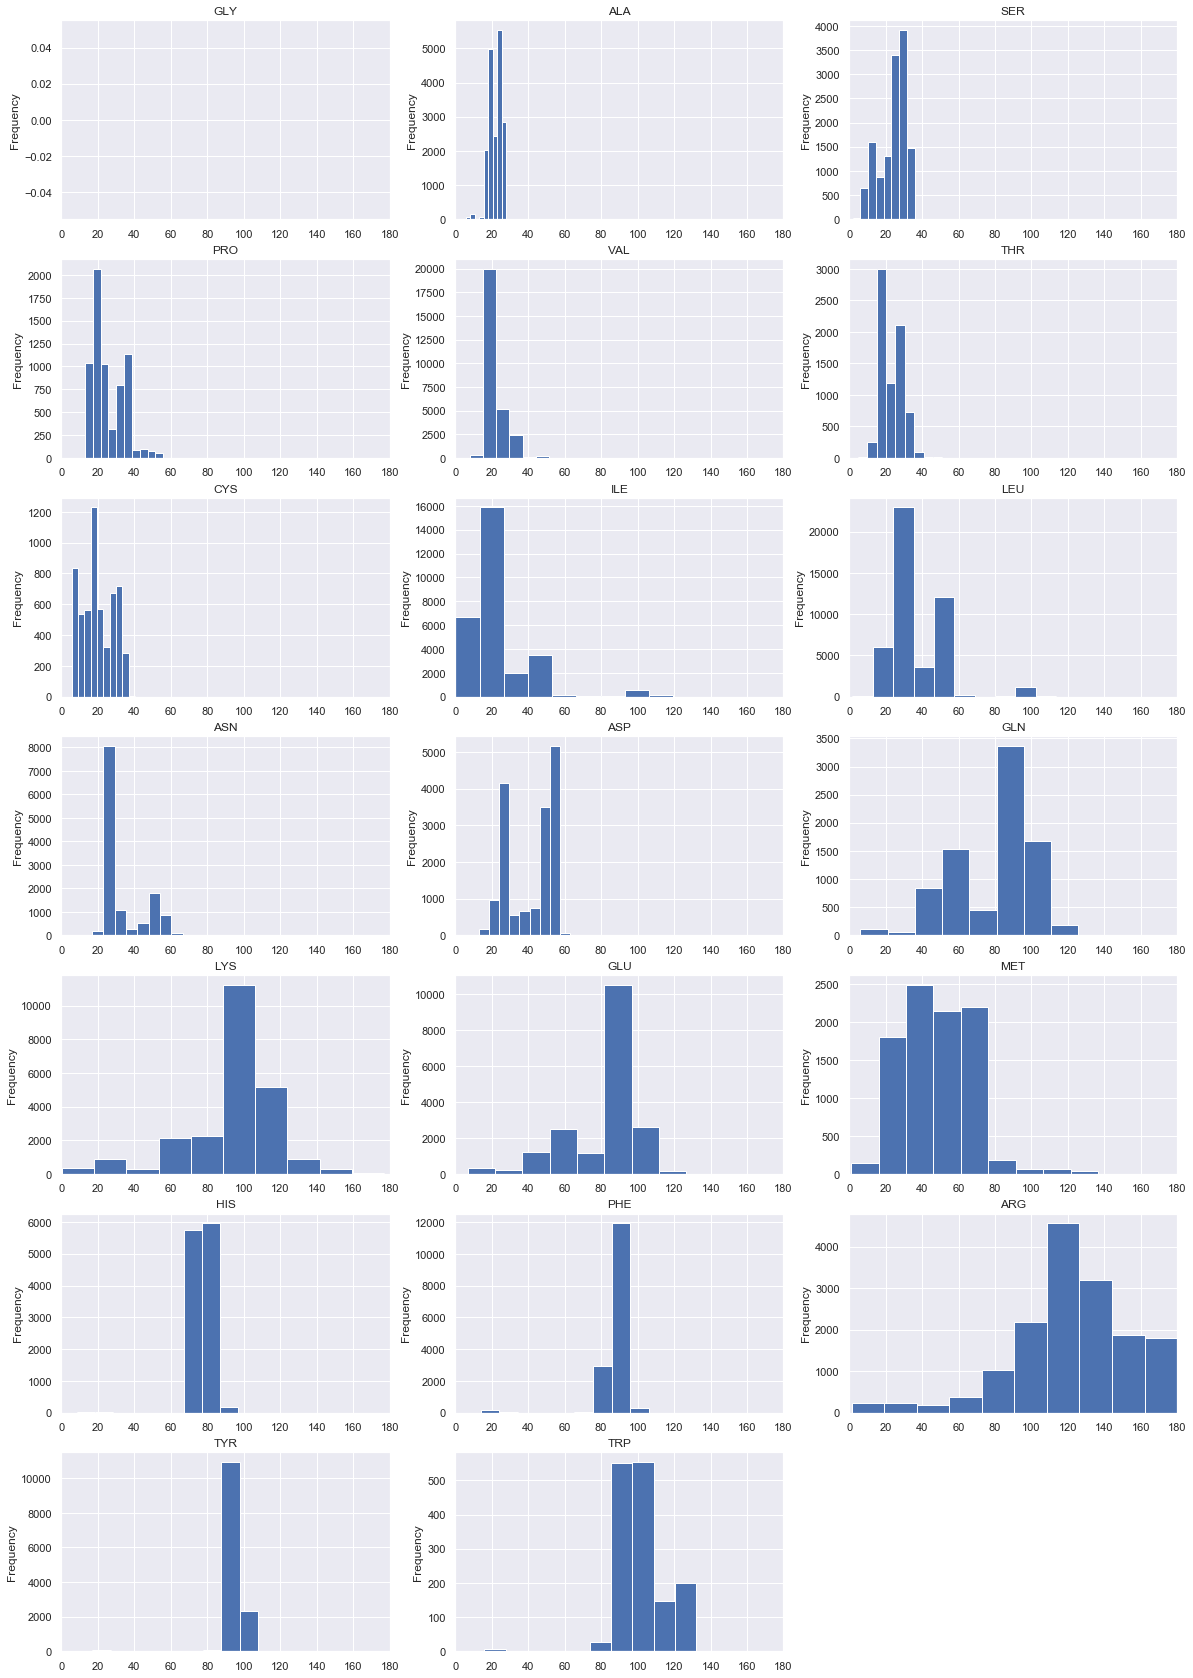

In [19]:
sca_stats.plot_side_chain_angle_distribution(
    path_to_results / 'features', 
    kind='histograms'
)

Get mean and median of side chain angles per amino acid and save to file. 
Use these values for residues with missing Ca/Cb atoms.

In [20]:
sca_stats.get_mean_median(
    from_file=path_to_results / 'features' / 'stats_missing_ca_cb_and_sca.p'
)

,sca_mean,sca_median
residue_name,,
ALA,21.86,22.53
ARG,121.47,122.24
ASN,33.58,27.18
ASP,41.52,48.66
CAF,132.03,132.03
CME,64.61,64.79
CSS,46.53,46.53
CYS,19.89,18.79
GLN,80.15,89.88
